In [86]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%matplotlib inline

# Algorytmy ewolucyjne, lista 4

## Zadanie 1. (2 punkty)

### a) 
Zapoznaj się ze notebookiem IPythona pokazującym podstawowe mechanizmy strategii ewolucyjnych umieszczonym w materiałach do wykładu.

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

In [3]:
# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [4]:
# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [5]:
# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [6]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(12, 8))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()

In [7]:
def plot_contour_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(9, 9))
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    plt.contour(X, Y, Z, 50)
    plt.title(title)
    plt.show()

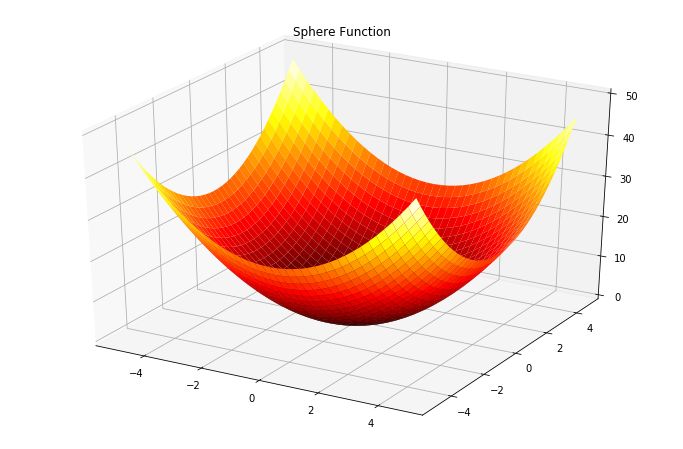

In [8]:
plot_3D_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

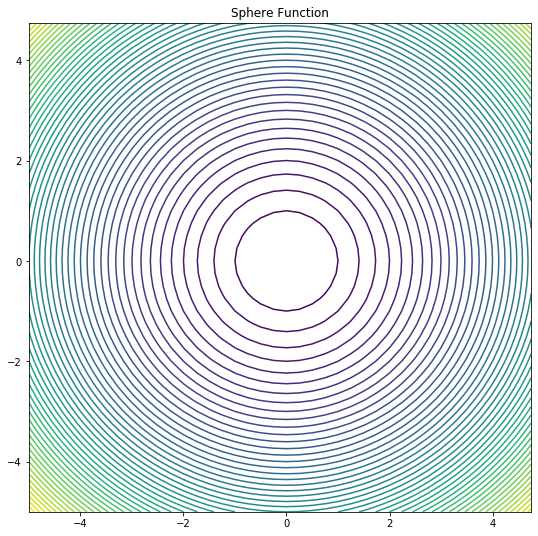

In [9]:
plot_contour_benchmark_function(objective_function_F1, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

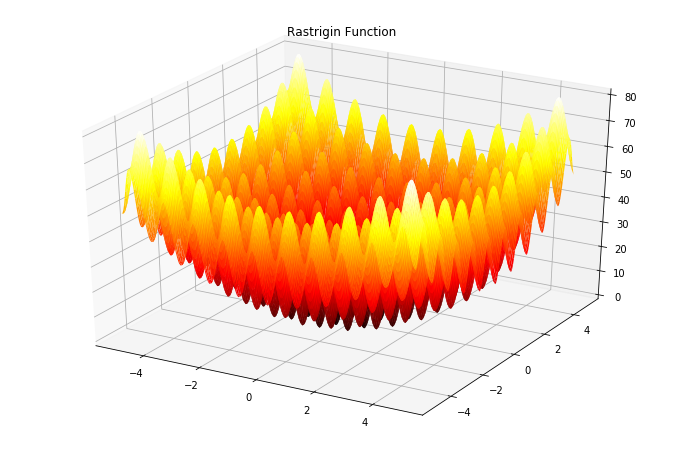

In [10]:
plot_3D_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

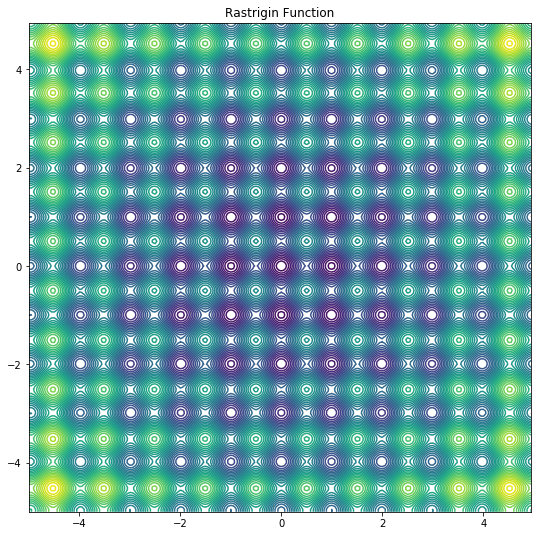

In [11]:
plot_contour_benchmark_function(objective_function_F6, np.arange(-5, 5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')

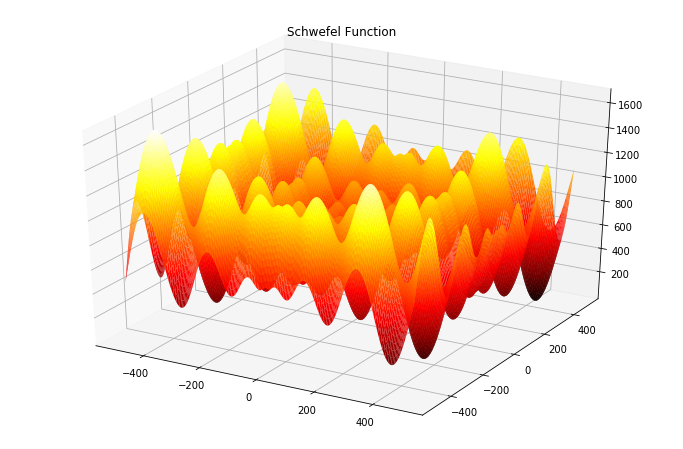

In [12]:
plot_3D_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

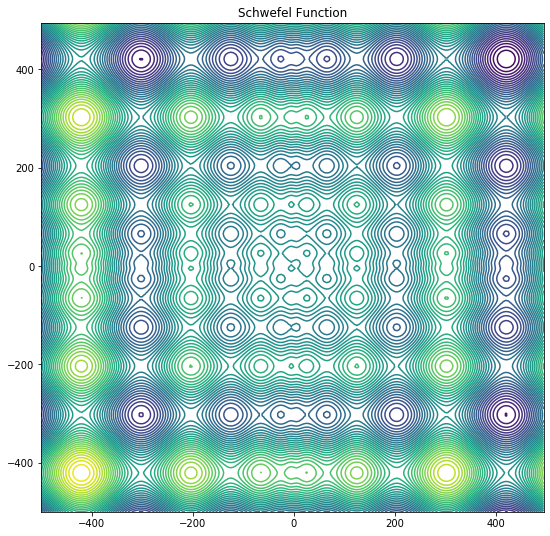

In [13]:
plot_contour_benchmark_function(objective_function_F7, np.arange(-500, 500, 5), np.arange(-500, 500, 5), 'Schwefel Function')

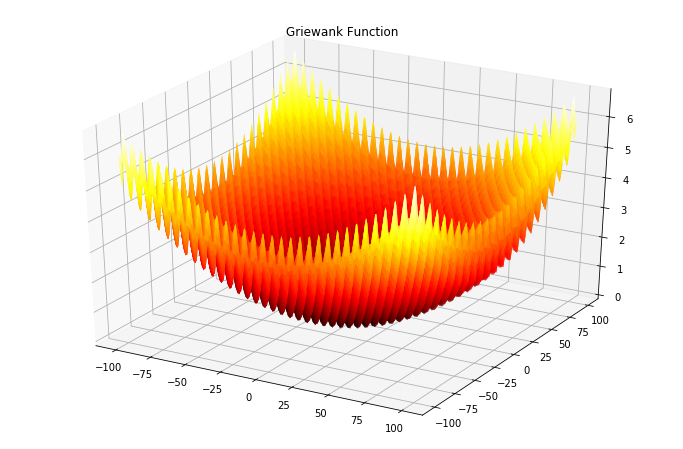

In [14]:
plot_3D_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

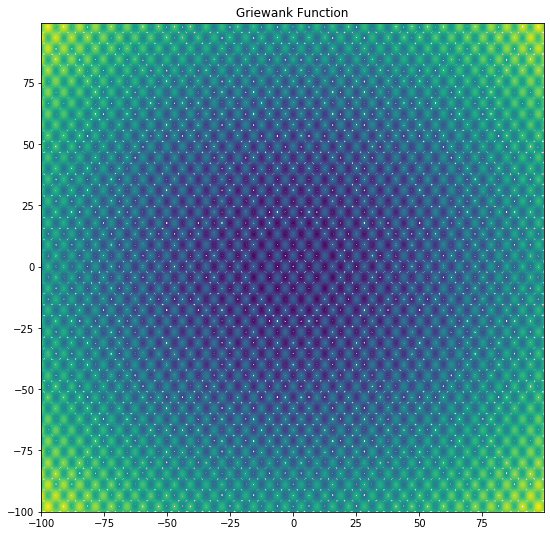

In [15]:
plot_contour_benchmark_function(objective_function_F8, np.arange(-100, 100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')

In [16]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### b)
Sprawdź działanie zaimplementowanej w notebooku strategii ewolucyjnej dla funkcji sferycznej, Rastrigina, Schwefela i Griewanka o wymiarowości d = 10, 20, 50, 100.

Sprawdź wpływ parametrów algorytmu na jego działanie.

#### Działanie strategii ewolucyjnej dla funkcji sferycznej F1

Iteration 0000 : best score = -4612.76105658, mean score = -26612.20504728.
Iteration 0010 : best score = -44.28166255, mean score = -219.31915023.
Iteration 0020 : best score = -0.08357198, mean score = -0.61557817.
Iteration 0030 : best score = -0.00025547, mean score = -0.00151032.
Iteration 0040 : best score = -0.00000048, mean score = -0.00000276.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


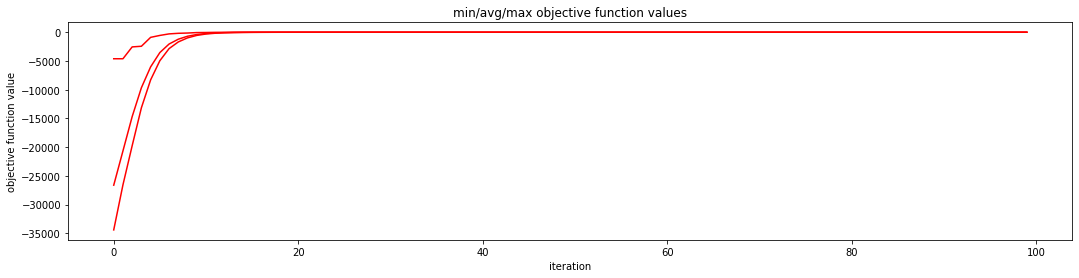

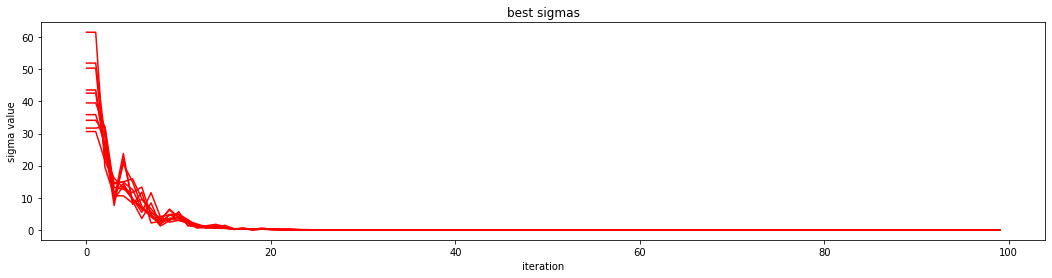

In [17]:
d = 10
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -23864.12468680, mean score = -59786.87750656.
Iteration 0010 : best score = -931.90069209, mean score = -2218.74027091.
Iteration 0020 : best score = -14.99678871, mean score = -49.69186946.
Iteration 0030 : best score = -0.44968275, mean score = -1.45204355.
Iteration 0040 : best score = -0.01693563, mean score = -0.04223053.
Iteration 0050 : best score = -0.00045351, mean score = -0.00107297.
Iteration 0060 : best score = -0.00001161, mean score = -0.00002810.
Iteration 0070 : best score = -0.00000026, mean score = -0.00000082.
Iteration 0080 : best score = -0.00000001, mean score = -0.00000002.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


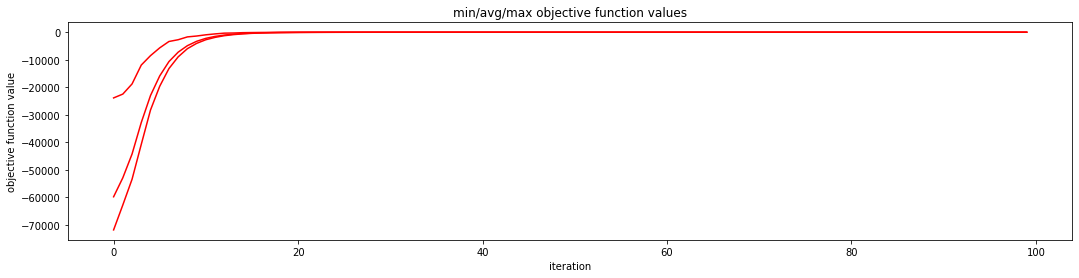

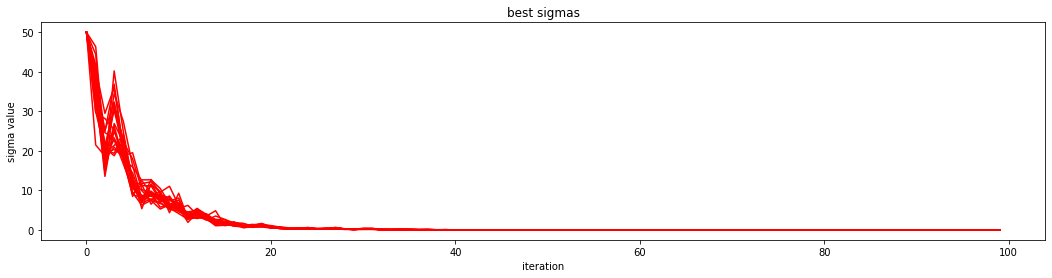

In [20]:
d = 20
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -88385.87875896, mean score = -160691.05652404.
Iteration 0010 : best score = -18666.08624116, mean score = -27934.15456568.
Iteration 0020 : best score = -3285.17933337, mean score = -4726.35820464.
Iteration 0030 : best score = -709.93537191, mean score = -1019.34127258.
Iteration 0040 : best score = -158.18495179, mean score = -225.61709568.
Iteration 0050 : best score = -36.83397071, mean score = -50.80904682.
Iteration 0060 : best score = -8.36189718, mean score = -11.69267588.
Iteration 0070 : best score = -2.09913109, mean score = -2.85654004.
Iteration 0080 : best score = -0.50998450, mean score = -0.70255371.
Iteration 0090 : best score = -0.11142416, mean score = -0.16951907.
Iteration 0100 : best score = -0.02990418, mean score = -0.04076222.
Iteration 0110 : best score = -0.00698590, mean score = -0.01013973.
Iteration 0120 : best score = -0.00159115, mean score = -0.00245521.
Iteration 0130 : best score = -0.00042747, mean score = -0.00062864.

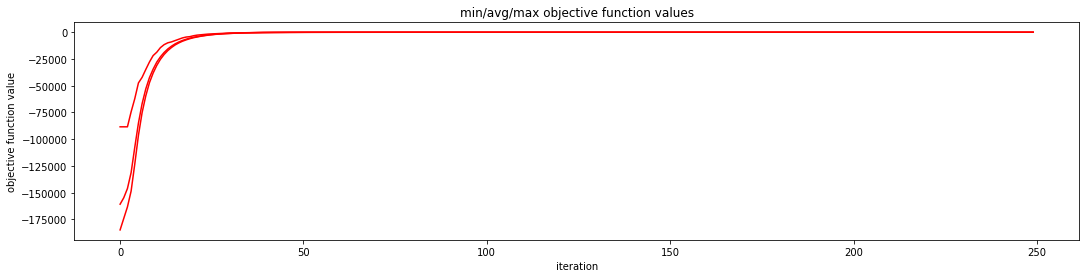

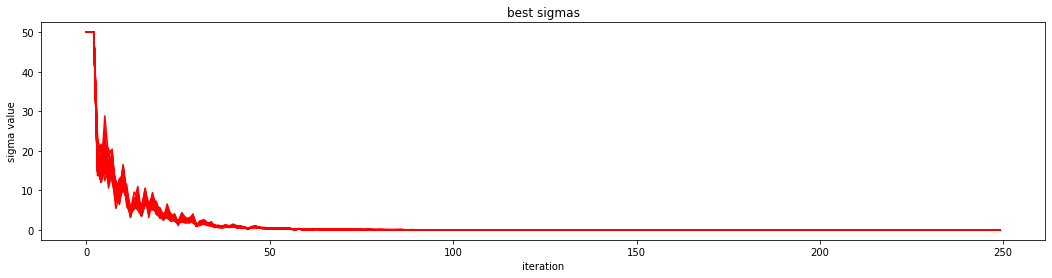

In [24]:
d = 50
N = 2000
T = 250
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -217524.47189273, mean score = -329294.00837760.
Iteration 0010 : best score = -99311.13140263, mean score = -123538.37339921.
Iteration 0020 : best score = -37372.11190855, mean score = -44911.00382336.
Iteration 0030 : best score = -17292.65393968, mean score = -20661.30854842.
Iteration 0040 : best score = -8529.81017913, mean score = -9872.16467365.
Iteration 0050 : best score = -4069.56683650, mean score = -4808.73813285.
Iteration 0060 : best score = -1964.04722226, mean score = -2341.27217338.
Iteration 0070 : best score = -943.65986277, mean score = -1143.68371087.
Iteration 0080 : best score = -458.91778934, mean score = -546.56687868.
Iteration 0090 : best score = -214.71766549, mean score = -264.14778360.
Iteration 0100 : best score = -99.73250419, mean score = -126.47379145.
Iteration 0110 : best score = -49.15264477, mean score = -60.98625652.
Iteration 0120 : best score = -24.83121869, mean score = -29.67693126.
Iteration 0130 : best score = 

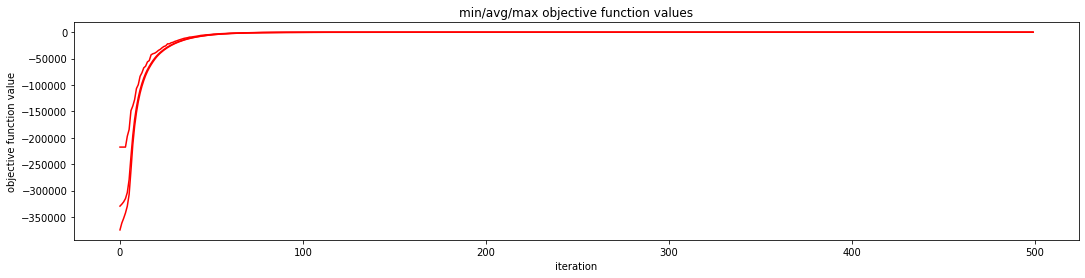

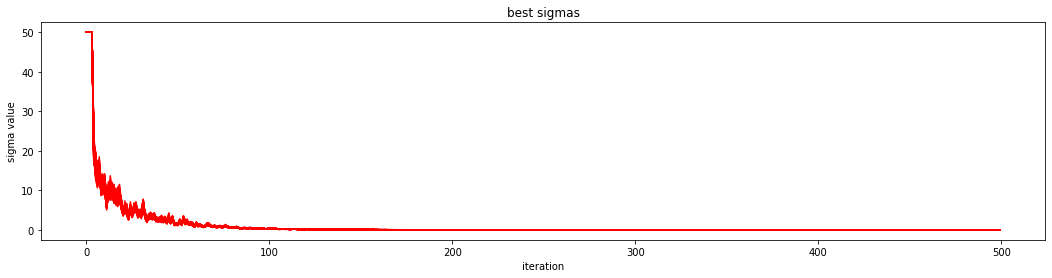

In [26]:
d = 100
N = 3000
T = 500

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

#### Działanie strategii ewolucyjnej dla funkcji Rastrigina F6

Iteration 0000 : best score = -7622.16174691, mean score = -25998.48807991.
Iteration 0010 : best score = -110.78723118, mean score = -336.18664438.
Iteration 0020 : best score = -30.00418321, mean score = -77.74806133.
Iteration 0030 : best score = -22.32038706, mean score = -62.35711863.
Iteration 0040 : best score = -22.32038706, mean score = -56.30686038.
Iteration 0050 : best score = -22.32038706, mean score = -52.32425575.
Iteration 0060 : best score = -4.77775978, mean score = -46.73523219.
Iteration 0070 : best score = -0.07345062, mean score = -0.41966179.
Iteration 0080 : best score = -0.00010778, mean score = -0.00090683.
Iteration 0090 : best score = -0.00000035, mean score = -0.00000195.
Iteration 0100 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0110 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0120 : best score = 0.00000000, mean score = -0.00000000.
Iteration 0130 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0140 : 

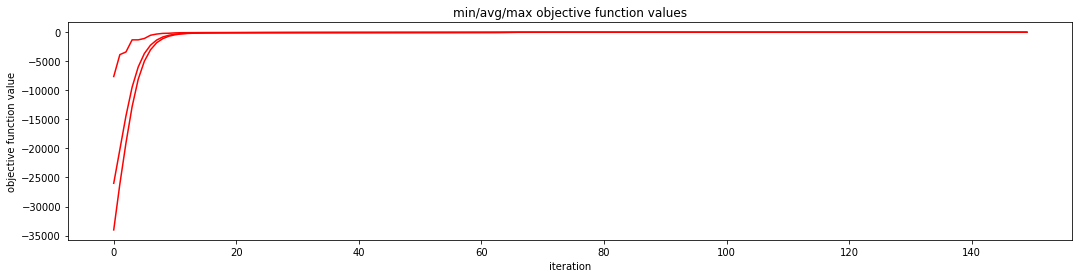

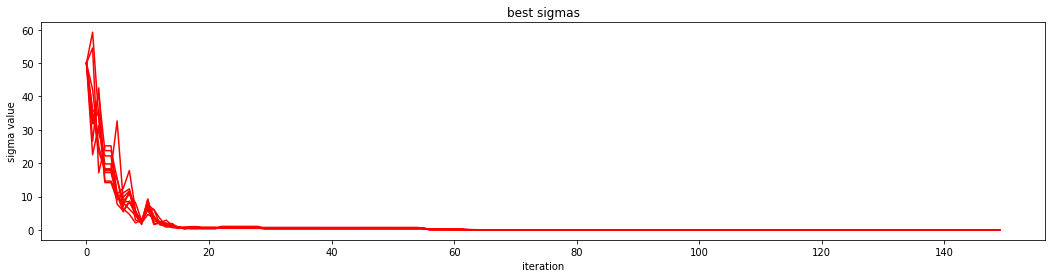

In [30]:
d = 10
N = 2000
T = 150

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -21584.09982057, mean score = -59647.62226675.
Iteration 0010 : best score = -930.33128012, mean score = -2407.96834503.
Iteration 0020 : best score = -149.76525687, mean score = -246.53480893.
Iteration 0030 : best score = -62.70137549, mean score = -172.91045880.
Iteration 0040 : best score = -62.70137549, mean score = -154.69619164.
Iteration 0050 : best score = -54.84861930, mean score = -145.65425684.
Iteration 0060 : best score = -54.84861930, mean score = -139.88209760.
Iteration 0070 : best score = -54.84861930, mean score = -134.91778311.
Iteration 0080 : best score = -54.84861930, mean score = -117.77268978.
Iteration 0090 : best score = -20.62019909, mean score = -26.42043767.
Iteration 0100 : best score = -17.95430588, mean score = -18.09199238.
Iteration 0110 : best score = -17.91010539, mean score = -17.91246483.
Iteration 0120 : best score = -17.90928740, mean score = -17.90932663.
Iteration 0130 : best score = -17.90926377, mean score = -17

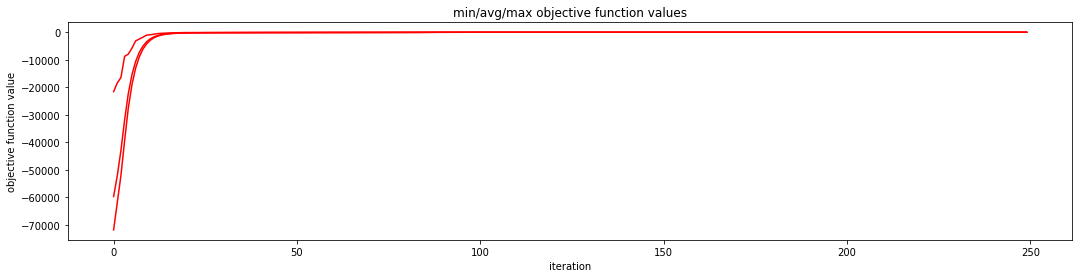

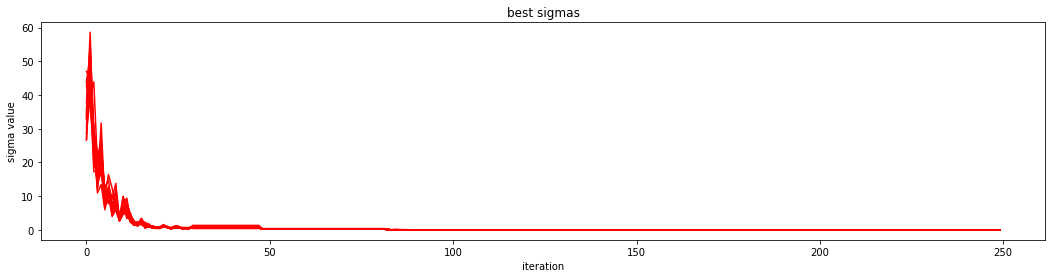

In [35]:
d = 20
N = 4000
T = 250

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -85065.80679918, mean score = -159290.61528179.
Iteration 0010 : best score = -14356.18263343, mean score = -20187.97663199.
Iteration 0020 : best score = -2498.42224554, mean score = -3329.91974240.
Iteration 0030 : best score = -798.53372848, mean score = -960.75678154.
Iteration 0040 : best score = -503.31082887, mean score = -606.70766635.
Iteration 0050 : best score = -390.86625465, mean score = -527.77705535.
Iteration 0060 : best score = -381.89541579, mean score = -493.71674211.
Iteration 0070 : best score = -301.82533830, mean score = -401.78425621.
Iteration 0080 : best score = -141.80484498, mean score = -168.32434059.
Iteration 0090 : best score = -100.01414337, mean score = -104.33750131.
Iteration 0100 : best score = -89.94887571, mean score = -90.68340391.
Iteration 0110 : best score = -88.70399394, mean score = -88.78911628.
Iteration 0120 : best score = -88.57282077, mean score = -88.58219043.
Iteration 0130 : best score = -88.55481218, me

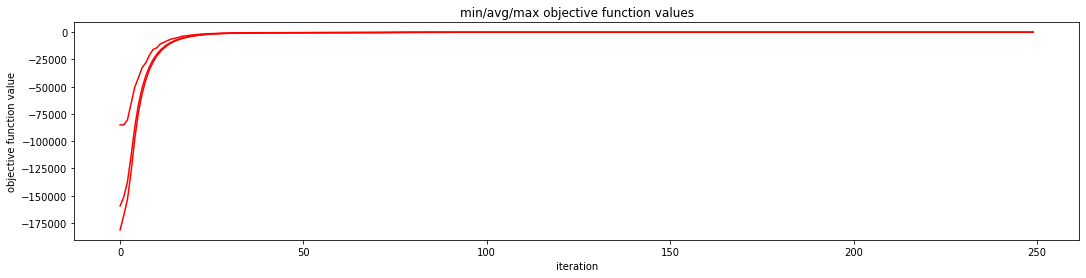

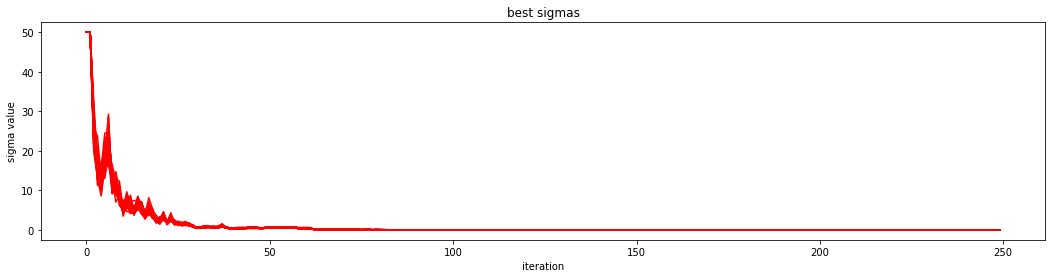

In [37]:
d = 50
N = 3000
T = 250

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 3*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -241503.96302330, mean score = -330364.47901835.
Iteration 0010 : best score = -83243.60769971, mean score = -100527.67159743.
Iteration 0020 : best score = -29187.50393202, mean score = -34343.63859342.
Iteration 0030 : best score = -11728.09343781, mean score = -13815.96266174.
Iteration 0040 : best score = -5448.20393400, mean score = -6170.09670312.
Iteration 0050 : best score = -2714.32064698, mean score = -3088.37556877.
Iteration 0060 : best score = -1727.20100561, mean score = -1963.99845043.
Iteration 0070 : best score = -1341.30942929, mean score = -1536.27092269.
Iteration 0080 : best score = -1166.22638184, mean score = -1352.32905425.
Iteration 0090 : best score = -1114.60005305, mean score = -1258.81510193.
Iteration 0100 : best score = -842.60555134, mean score = -960.53423562.
Iteration 0110 : best score = -588.05020181, mean score = -626.32558835.
Iteration 0120 : best score = -475.44452959, mean score = -492.62932746.
Iteration 0130 : bes

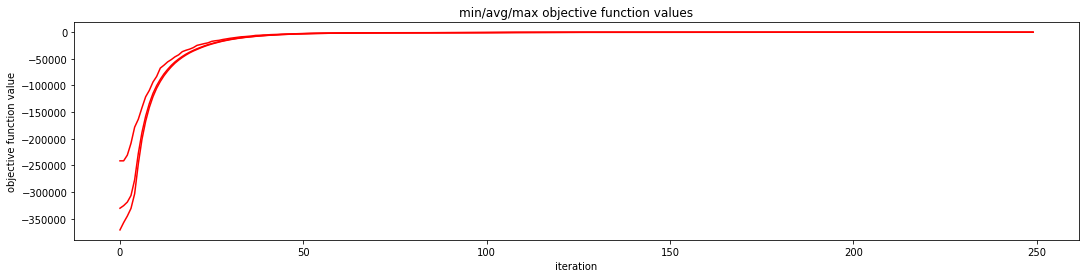

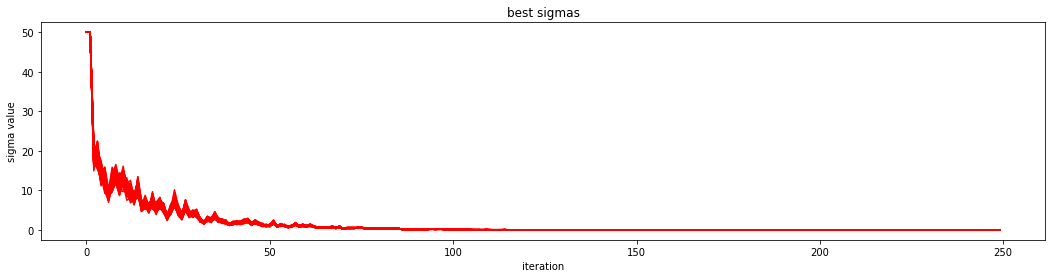

In [38]:
d = 100
N = 3000
T = 250

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 3*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

#### Działanie strategii ewolucyjnej dla funkcji Griewanka F8

Iteration 0000 : best score = -1.98509463, mean score = -7.60545706.
Iteration 0010 : best score = -0.61110860, mean score = -1.04797229.
Iteration 0020 : best score = -0.07723436, mean score = -0.48394655.
Iteration 0030 : best score = -0.00030501, mean score = -0.00202785.
Iteration 0040 : best score = -0.00000133, mean score = -0.00000950.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000003.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = 0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = 0.00000000, mean score = 0.00000000.


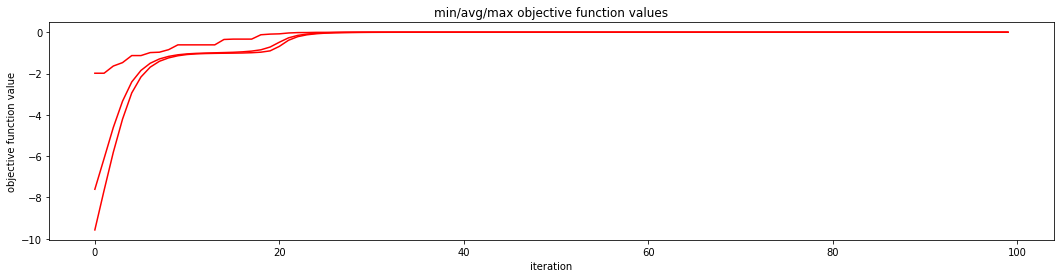

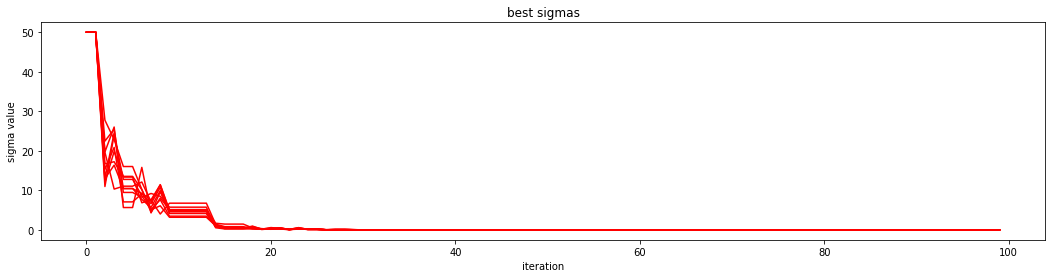

In [19]:
d = 10
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -8.58827448, mean score = -16.02962115.
Iteration 0010 : best score = -1.29167926, mean score = -1.75849369.
Iteration 0020 : best score = -0.83910492, mean score = -1.00995362.
Iteration 0030 : best score = -0.13355343, mean score = -0.18577488.
Iteration 0040 : best score = -0.02486930, mean score = -0.03462261.
Iteration 0050 : best score = -0.00270640, mean score = -0.00536560.
Iteration 0060 : best score = -0.00020444, mean score = -0.00044164.
Iteration 0070 : best score = -0.00001240, mean score = -0.00002410.
Iteration 0080 : best score = -0.00000185, mean score = -0.00000264.
Iteration 0090 : best score = -0.00000021, mean score = -0.00000032.
Iteration 0100 : best score = -0.00000002, mean score = -0.00000003.
Iteration 0110 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0120 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0130 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0140 : best score = -0.

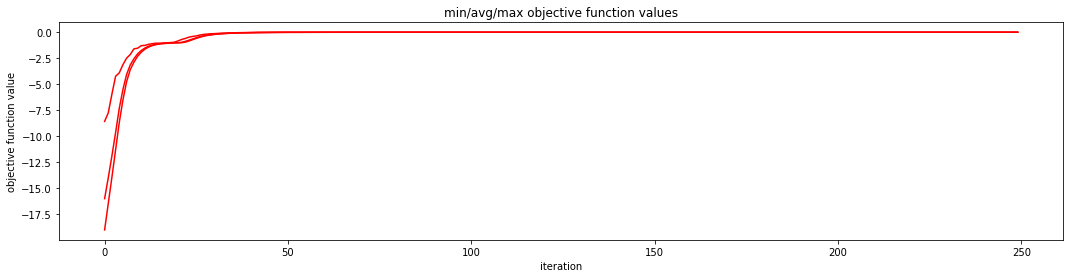

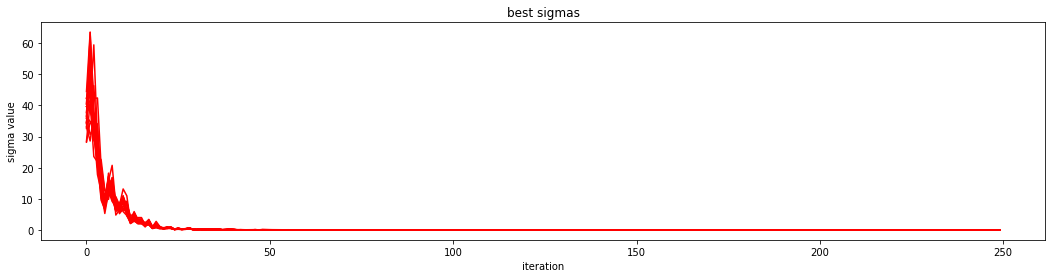

In [41]:
d = 20
N = 500
T = 250

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -27.89344846, mean score = -40.68579260.
Iteration 0010 : best score = -6.46218643, mean score = -8.41857845.
Iteration 0020 : best score = -2.04476931, mean score = -2.52143958.
Iteration 0030 : best score = -1.31660992, mean score = -1.40099844.
Iteration 0040 : best score = -1.08175854, mean score = -1.10654689.
Iteration 0050 : best score = -0.97832183, mean score = -1.01708306.
Iteration 0060 : best score = -0.62521598, mean score = -0.70029985.
Iteration 0070 : best score = -0.36537045, mean score = -0.40732678.
Iteration 0080 : best score = -0.22370537, mean score = -0.25251643.
Iteration 0090 : best score = -0.13938340, mean score = -0.15311809.
Iteration 0100 : best score = -0.07996658, mean score = -0.09226800.
Iteration 0110 : best score = -0.05248701, mean score = -0.05870649.
Iteration 0120 : best score = -0.03162539, mean score = -0.03566395.
Iteration 0130 : best score = -0.01956521, mean score = -0.02210310.
Iteration 0140 : best score = -0

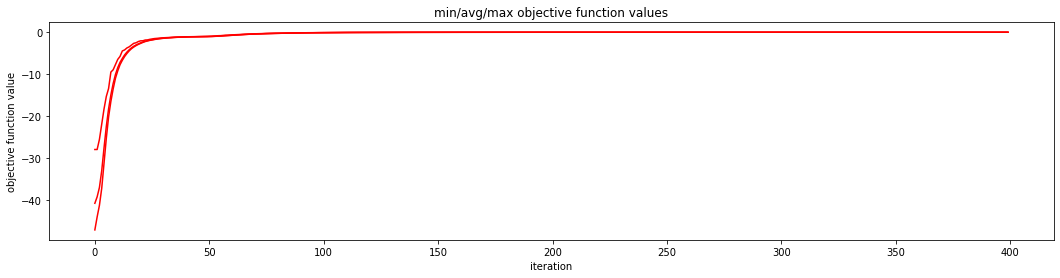

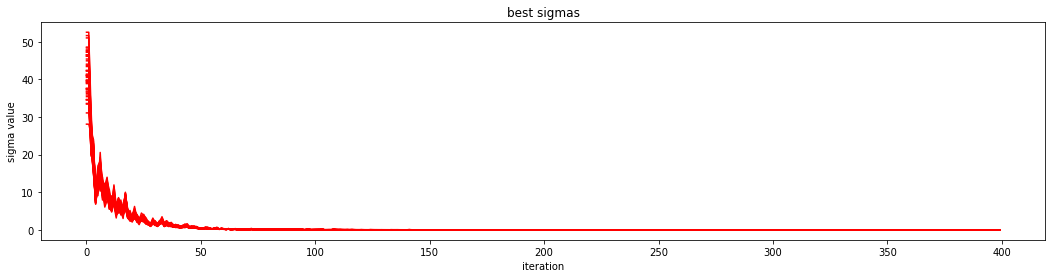

In [43]:
d = 50
N = 500
T = 400

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -62.86487176, mean score = -83.64941903.
Iteration 0050 : best score = -2.49018741, mean score = -2.71713112.
Iteration 0100 : best score = -1.02026761, mean score = -1.04233212.
Iteration 0150 : best score = -0.40012106, mean score = -0.41700489.
Iteration 0200 : best score = -0.14877681, mean score = -0.15493223.
Iteration 0250 : best score = -0.06257182, mean score = -0.06559047.
Iteration 0300 : best score = -0.02501640, mean score = -0.02586361.
Iteration 0350 : best score = -0.00793071, mean score = -0.00830308.
Iteration 0400 : best score = -0.00283719, mean score = -0.00296290.
Iteration 0450 : best score = -0.00105851, mean score = -0.00112294.
Iteration 0500 : best score = -0.00046295, mean score = -0.00047721.
Iteration 0550 : best score = -0.00021309, mean score = -0.00022188.
Iteration 0600 : best score = -0.00010552, mean score = -0.00010850.
Iteration 0650 : best score = -0.00003545, mean score = -0.00003795.
Iteration 0700 : best score = -0

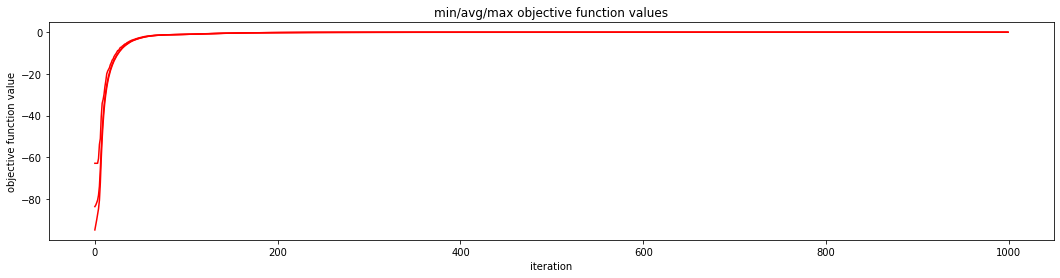

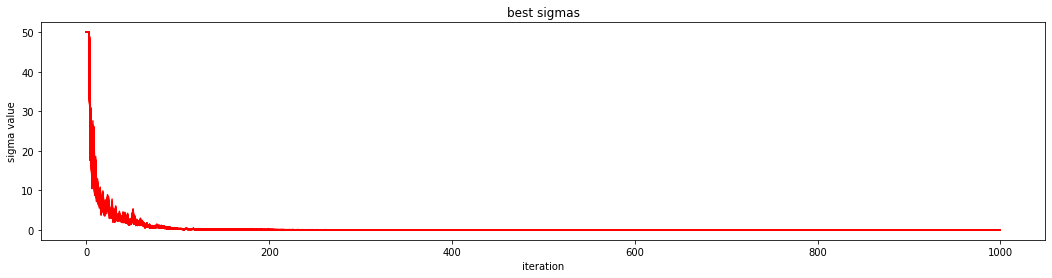

In [47]:
d = 100
N = 500
T = 1000

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 50)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

## Zadanie 2. (4 punkty)
Zapoznaj się z trzema modelami mutacji pokazanymi w notebooku. 

### Modele mutacji

In [17]:
N = 250
d = 2

objective_function = objective_function_F1a

original_individual = np.array([[1, 1]])

#### Przykład 1
Przykład 1:
$x_i=x_i+ε_i$, gdzie  $ε_i$  ma rozkład normalny  $N(0,σ^2)$ , zaś  $σ$ jest taka sama dla wszystkich  $i=1,2,…,d$

In [18]:
sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)

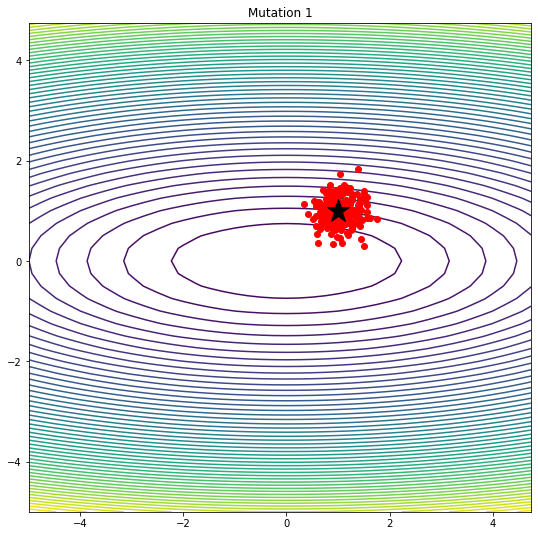

In [19]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 1')
plt.show()

#### Przykład 2
$x_i=x_i+ε_i$ , gdzie  $ε_i$  ma rozkład normalny  $N(0,σ^2_i)$ , zaś  $σ_i$  może być różna dla różnych  $i=1,2,…,d$

In [20]:
sigma = np.array([0.25, 0.5])
mutations = original_individual + sigma * np.random.randn(N, d)

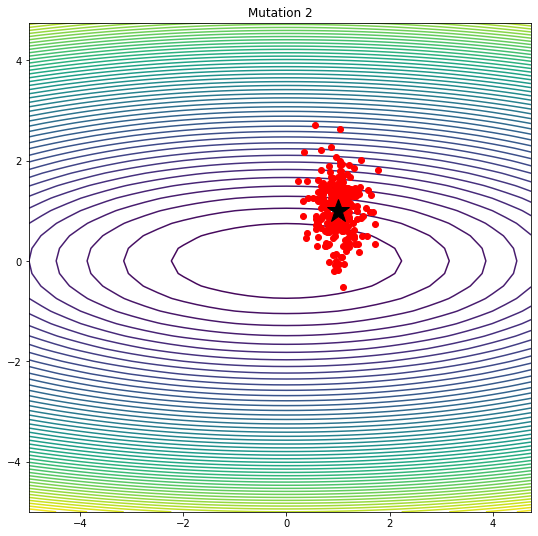

In [21]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 2')
plt.show()

#### Przykład 3
$x=x+ε$, gdzie $ε$ ma wielowymiarowy rozkład normalny  $N(0,Σ)$

In [22]:
S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)

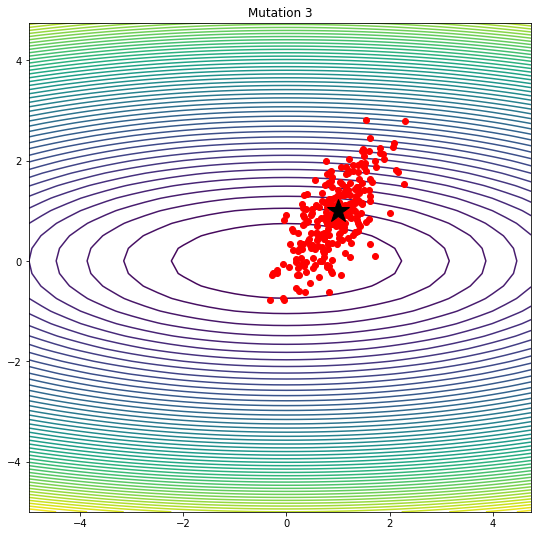

In [23]:
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

plt.figure(figsize=(9, 9))
plt.contour(X, Y, Z, 50)
plt.plot(mutations[:, 0], mutations[:, 1], 'ro')
plt.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
plt.title('Mutation 3')
plt.show()

### a) 
Dla każdego modelu mutacji, policz ile osobników po mutacji było lepszych od oryginalnego osobnika. Powtórz obliczenia kilkukrotnie i porównaj wyniki (ze względu na losowość algorytmu). 


In [59]:
def count_improvments(org, mutated, obj_func):
    org_score = obj_func(org)
    mutated_score = obj_func(mutated)
    return np.sum(mutated_score>org_score)

In [79]:
def test_counts(original_individual, objective_function, N=1000):
    results = []
    for _ in range(N):
        sigma = 0.25
        mutations = original_individual + sigma * np.random.randn(N, d)
        score1 = count_improvments(original_individual, mutations, objective_function)
        sigma = np.array([0.25, 0.5])
        mutations = original_individual + sigma * np.random.randn(N, d)
        score2 = count_improvments(original_individual, mutations, objective_function)
        S = np.array([[0.25, 0.25],[0.25, 0.5]])
        mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)
        score3 = count_improvments(original_individual, mutations, objective_function)
        results.append([score1, score2, score3])

    results = np.array(results)
    for method in [1,2,3]:
        print(f'Method {method}: {np.mean(results[:,method-1])}')

In [69]:
test_counts(original_individual, objective_function_F1a)

Method 1: 123.824
Method 2: 124.02
Method 3: 123.493


### b) 
Dla każdego modelu mutacji, policz wartość funkcji celu najlepszego osobnika po mutacji. Powtórz obliczenia kilkukrotnie i porównaj wyniki (ze względu na losowość algorytmu). 

In [70]:
def best_res(org,mutated,obj_func):
    mutated_score = obj_func(mutated)
    return np.max(mutated_score)

In [80]:
def test_max(original_individual, objective_function, N=1000):
    results = []
    for _ in range(N):
        sigma = 0.25
        mutations = original_individual + sigma * np.random.randn(N, d)
        score1 = best_res(original_individual, mutations, objective_function)
        sigma = np.array([0.25, 0.5])
        mutations = original_individual + sigma * np.random.randn(N, d)
        score2 = best_res(original_individual, mutations, objective_function)
        S = np.array([[0.25, 0.25],[0.25, 0.5]])
        mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)
        score3 = best_res(original_individual, mutations, objective_function)
        results.append([score1, score2, score3])

    results = np.array(results)
    for method in [1,2,3]:
        print(f'Method {method}: {np.mean(results[:,method-1])}')

In [72]:
test_max(original_individual, objective_function_F1a)

Method 1: -1.7207264887151414
Method 2: -0.47862063526053833
Method 3: -0.04050095027866744


### c)
Obliczenia z poprzednich punktów powtórz dla innych funkcji celu. 

#### F1B

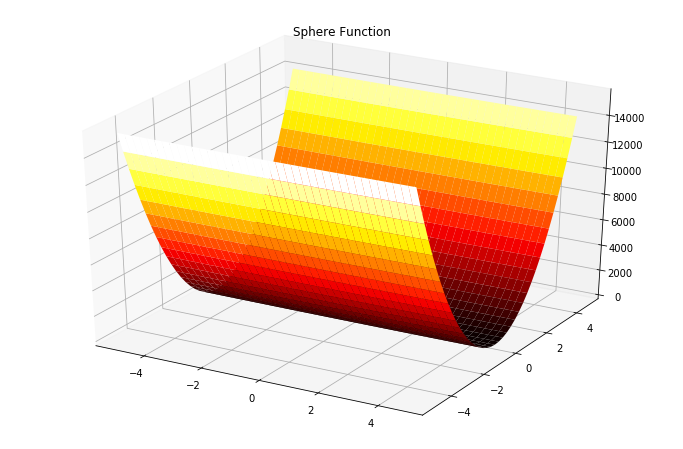

In [73]:
plot_3D_benchmark_function(objective_function_F1b, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

In [74]:
test_counts(original_individual, objective_function_F1b)

Method 1: 124.532
Method 2: 124.998
Method 3: 124.264


In [75]:
test_max(original_individual, objective_function_F1b)

Method 1: -62.29022866886106
Method 2: -1.2962332871113011
Method 3: -0.303176852265932


#### F1c

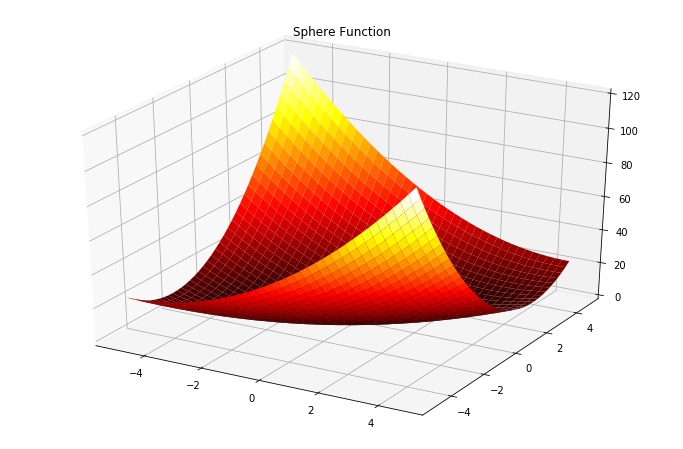

In [76]:
plot_3D_benchmark_function(objective_function_F1c, np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')

In [77]:
test_counts(original_individual, objective_function_F1c)

Method 1: 108.22
Method 2: 105.145
Method 3: 107.21


In [78]:
test_max(original_individual, objective_function_F1c)

Method 1: -0.26344843269789364
Method 2: -0.15765852008991915
Method 3: -0.013953725645037


### d)
Gdzie i w jakim celu używany jest rozkład Cholesky'ego macierzy kowariancji? 

$$\Sigma = AA^T \\
X \sim N(0,1) \\
XA + \mu \sim N(\mu,\Sigma)$$

### e)
Dla każdego modelu mutacji, narysuj elipsę odpowiadającą obszarowi 95% prawdopodobieństwa (tzn. zaznacz obszar, w którym z prawdopodobieństwem 95% znajdą się zmutowane osobniki). Policz długości osi głównych tych elips. 

In [90]:
# source - https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

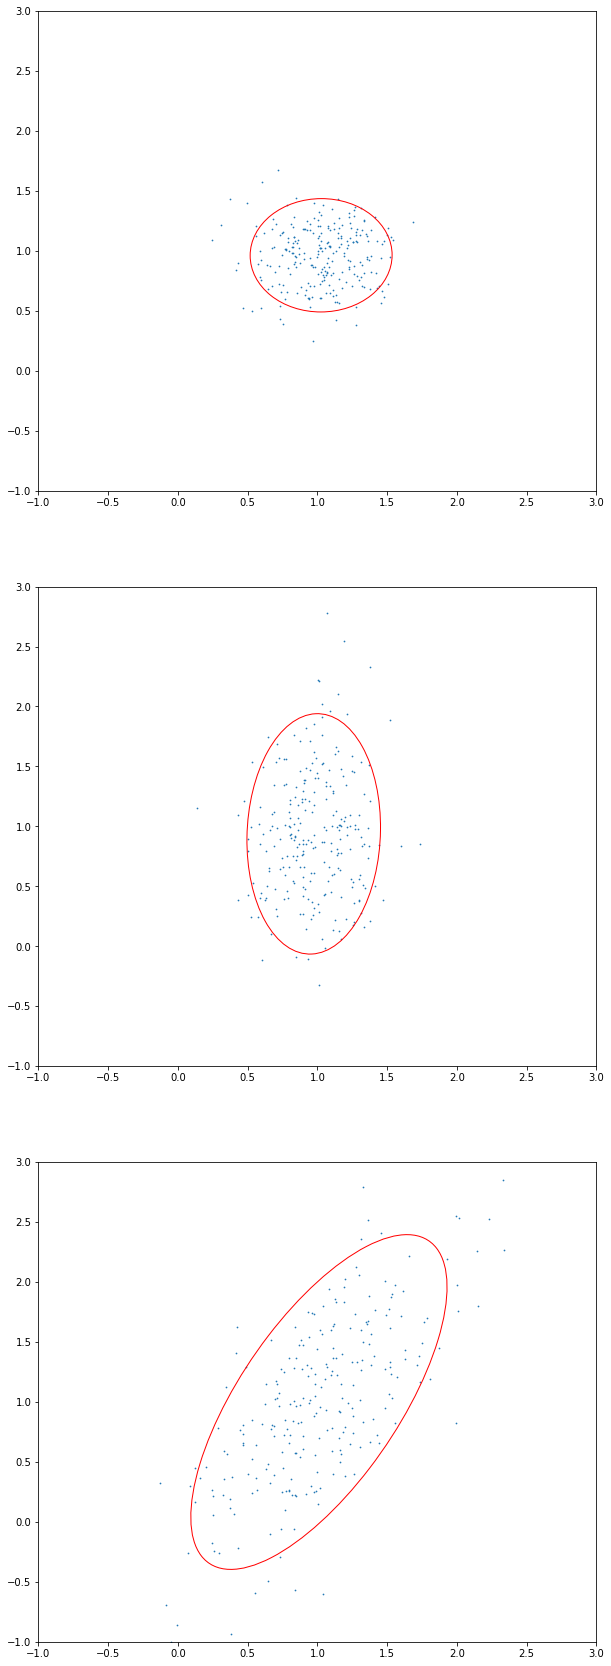

In [100]:
fig, ax = plt.subplots(3,1, figsize=(10,30))

sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)
x,y = mutations[:,0], mutations[:,1]
ax[0].scatter(x, y, s=0.5)
ax[0].set_ylim(-1,3)
ax[0].set_xlim(-1,3)
confidence_ellipse(x, y, ax[0], 1.95, edgecolor='red')

sigma = np.array([0.25, 0.5])
mutations = original_individual + sigma * np.random.randn(N, d)
x,y = mutations[:,0], mutations[:,1]
ax[1].scatter(x, y, s=0.5)
ax[1].set_ylim(-1,3)
ax[1].set_xlim(-1,3)
confidence_ellipse(x, y, ax[1], 1.95, edgecolor='red')

S = np.array([[0.25, 0.25],[0.25, 0.5]])
mutations = original_individual + np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)
x,y = mutations[:,0], mutations[:,1]
ax[2].scatter(x, y, s=0.5)
ax[2].set_ylim(-1,3)
ax[2].set_xlim(-1,3)
confidence_ellipse(x, y, ax[2], 1.95, edgecolor='red')

plt.show()

## Zadanie 3. (4 punkty)

### a) 
Sprawdź działanie zaimplementowanej w notebooku strategii ewolucyjnej dla zmodyfikowanych funkcji sferycznych. 


Iteration 0000 : best score = -1.91610300, mean score = -6593.95688216.
Iteration 0020 : best score = -0.08990055, mean score = -54.13858091.
Iteration 0040 : best score = -0.00732308, mean score = -13.68800601.
Iteration 0060 : best score = -0.00529418, mean score = -5.59898750.
Iteration 0080 : best score = -0.00259073, mean score = -2.69655288.
Iteration 0100 : best score = -0.00259073, mean score = -1.49301968.
Iteration 0120 : best score = -0.00082107, mean score = -0.87707272.
Iteration 0140 : best score = -0.00068675, mean score = -0.55467116.
Iteration 0160 : best score = -0.00002243, mean score = -0.35318277.
Iteration 0180 : best score = -0.00002243, mean score = -0.22953206.
Iteration 0200 : best score = -0.00002243, mean score = -0.14981867.
Iteration 0220 : best score = -0.00002243, mean score = -0.09665499.
Iteration 0240 : best score = -0.00002243, mean score = -0.06218764.
Iteration 0260 : best score = -0.00002243, mean score = -0.03926243.
Iteration 0280 : best score =

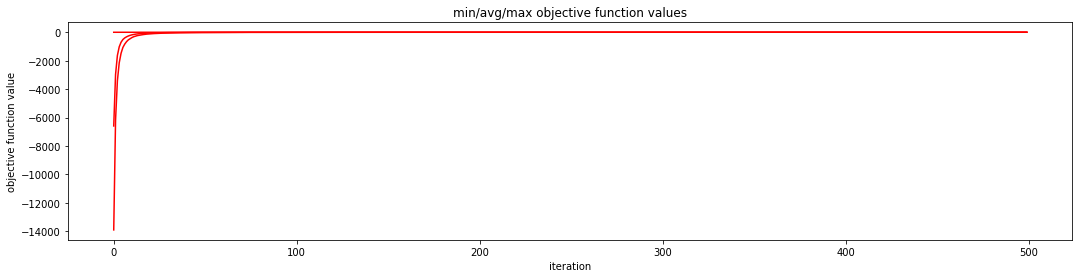

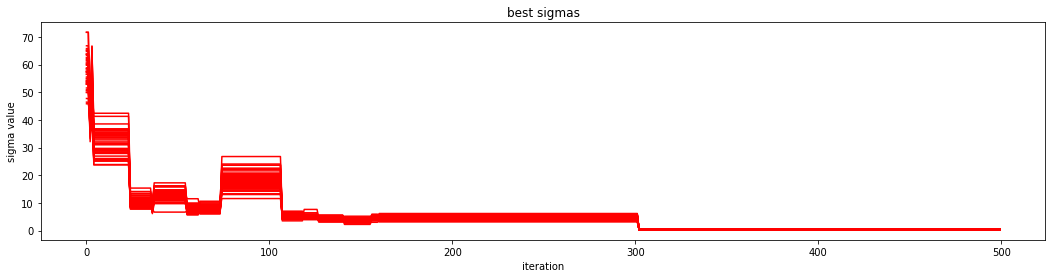

In [103]:
d = 50
N = 2000
T = 500
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1a, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -29.43059471, mean score = -187012.98960465.
Iteration 0020 : best score = -0.18483563, mean score = -1048.90984644.
Iteration 0040 : best score = -0.18483563, mean score = -308.89323958.
Iteration 0060 : best score = -0.18483563, mean score = -138.81759271.
Iteration 0080 : best score = -0.10902022, mean score = -76.84410536.
Iteration 0100 : best score = -0.07040043, mean score = -45.63592084.
Iteration 0120 : best score = -0.00239173, mean score = -30.35250127.
Iteration 0140 : best score = -0.00125335, mean score = -21.09111683.
Iteration 0160 : best score = -0.00125335, mean score = -14.94420053.
Iteration 0180 : best score = -0.00125335, mean score = -11.45993643.
Iteration 0200 : best score = -0.00125335, mean score = -8.87962798.
Iteration 0220 : best score = -0.00125335, mean score = -7.04207976.
Iteration 0240 : best score = -0.00125335, mean score = -5.48831229.
Iteration 0260 : best score = -0.00042475, mean score = -4.43570246.
Iteration 0280 

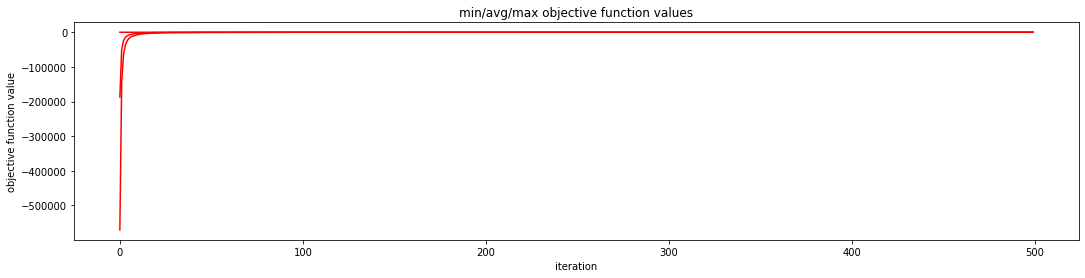

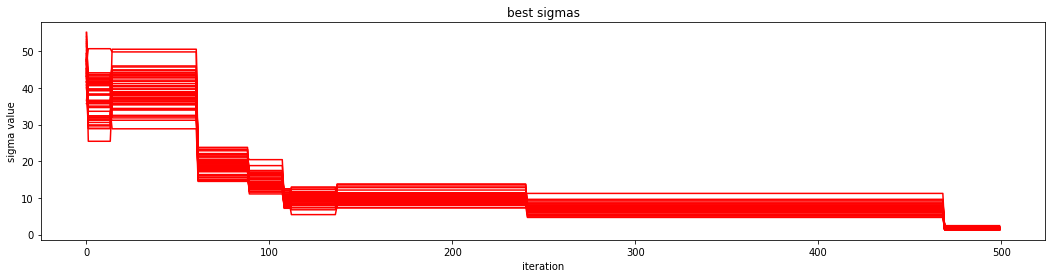

In [104]:
d = 50
N = 2000
T = 500
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1b, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -1.08503890, mean score = -1717.51231926.
Iteration 0020 : best score = -0.01701065, mean score = -15.95210960.
Iteration 0040 : best score = -0.00050571, mean score = -3.56981632.
Iteration 0060 : best score = -0.00050571, mean score = -1.16067294.
Iteration 0080 : best score = -0.00050571, mean score = -0.46724192.
Iteration 0100 : best score = -0.00008811, mean score = -0.22312143.
Iteration 0120 : best score = -0.00002620, mean score = -0.11395572.
Iteration 0140 : best score = -0.00002620, mean score = -0.05821968.
Iteration 0160 : best score = -0.00001253, mean score = -0.03200780.
Iteration 0180 : best score = -0.00001253, mean score = -0.01965406.
Iteration 0200 : best score = -0.00001253, mean score = -0.01219810.
Iteration 0220 : best score = -0.00001253, mean score = -0.00722975.
Iteration 0240 : best score = -0.00000450, mean score = -0.00416597.
Iteration 0260 : best score = -0.00000224, mean score = -0.00248876.
Iteration 0280 : best score = 

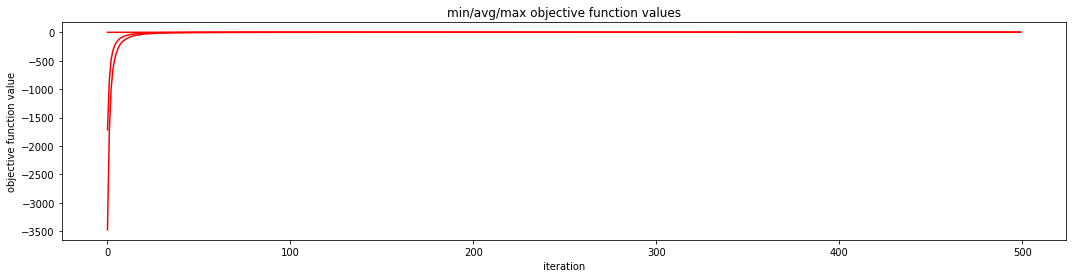

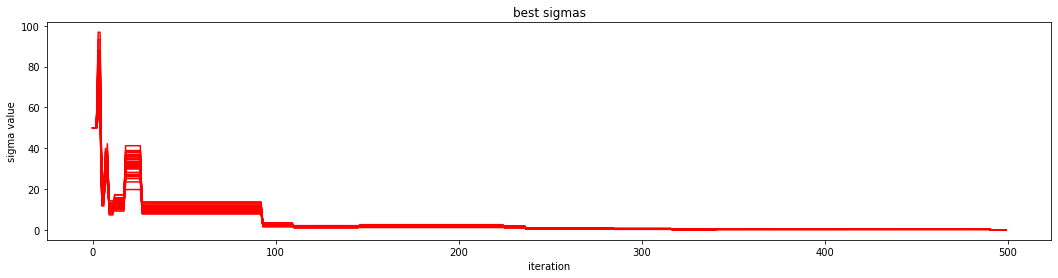

In [105]:
d = 50
N = 2000
T = 500
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1c, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### b)
Sprawdź czy zmiana modelu mutacji w zaimplementowanej strategii ewolucyjnej zmieni skuteczność algorytmu. Rozważ przykładowe modele mutacji pokazane w notebooku i inne własne pomysły. 


In [120]:
def es_with_mutations(objective_function, mutation_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1, 1))
        children_population_solutions = mutation_function(children_population_solutions, children_population_sigmas, number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [183]:
def motate1(children_population_solutions, children_population_sigmas, N, d):
    return children_population_solutions + children_population_sigmas[:,0,0].reshape(N,1) * np.random.randn(N, d)
    
def motate2(children_population_solutions, children_population_sigmas, N, d):
    return children_population_solutions + children_population_sigmas[:,0,:] * np.random.randn(N, d)

def near_psd(x, epsilon=0):
    '''
    Calculates the nearest postive semi-definite matrix for a correlation/covariance matrix

    Parameters
    ----------
    x : array_like
      Covariance/correlation matrix
    epsilon : float
      Eigenvalue limit (usually set to zero to ensure positive definiteness)

    Returns
    -------
    near_cov : array_like
      closest positive definite covariance/correlation matrix

    Notes
    -----
    Document source
    http://www.quarchome.org/correlationmatrix.pdf

    '''

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    # Removing scaling factor of covariance matrix
    n = x.shape[0]
    var_list = np.array([np.sqrt(x[i,i]) for i in range(n)])
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])

    # getting the nearest correlation matrix
    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)))))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    # returning the scaling factors
    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])
    return near_cov

def motate3(children_population_solutions, children_population_sigmas, N, d):
    for i in range(N):
        A = np.triu(children_population_sigmas[i,:,:],1).T + np.triu(children_population_sigmas[i,:,:])
        A = near_psd(A)
        print(np.mean(np.linalg.eigvals(A) >= 0))
        children_population_solutions[i] += np.dot(np.random.randn(1, d), np.linalg.cholesky(A).T)
    return children_population_solutions

Iteration 0000 : best score = -3.44613269, mean score = -1775.74901659.
Iteration 0020 : best score = -0.03374812, mean score = -13.16131779.
Iteration 0040 : best score = -0.00574183, mean score = -2.83600113.
Iteration 0060 : best score = -0.00141512, mean score = -0.85034695.
Iteration 0080 : best score = -0.00040428, mean score = -0.26703224.
Iteration 0100 : best score = -0.00040428, mean score = -0.09454351.
Iteration 0120 : best score = -0.00001587, mean score = -0.03349800.
Iteration 0140 : best score = -0.00000469, mean score = -0.01233856.
Iteration 0160 : best score = -0.00000285, mean score = -0.00518082.
Iteration 0180 : best score = -0.00000209, mean score = -0.00239812.
Iteration 0200 : best score = -0.00000209, mean score = -0.00110453.
Iteration 0220 : best score = -0.00000087, mean score = -0.00052584.
Iteration 0240 : best score = -0.00000071, mean score = -0.00024361.


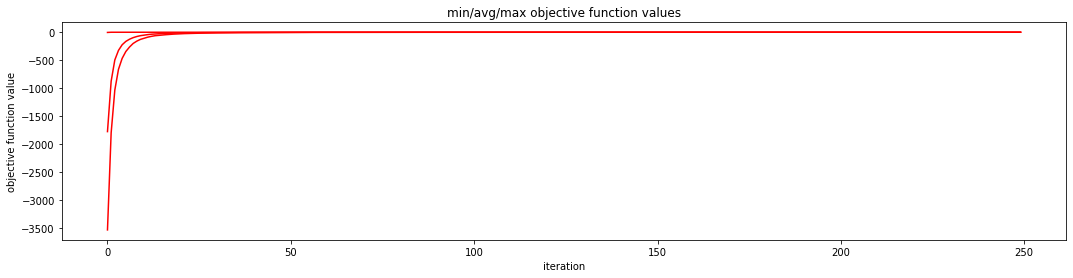

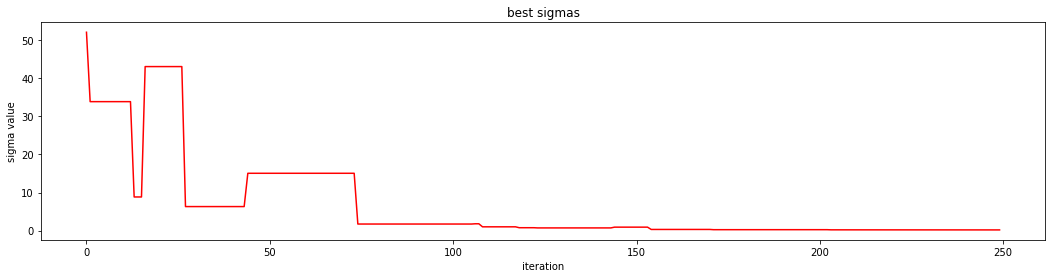

In [141]:
d = 50
N = 1000
T = 250
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es_with_mutations(
    objective_function_F1c, motate1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas[:,0,0], 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -4.46991188, mean score = -1741.41842389.
Iteration 0020 : best score = -0.03017216, mean score = -19.31006783.
Iteration 0040 : best score = -0.01359228, mean score = -4.88328893.
Iteration 0060 : best score = -0.00138807, mean score = -2.04175335.
Iteration 0080 : best score = -0.00019705, mean score = -0.96341928.
Iteration 0100 : best score = -0.00019705, mean score = -0.52079314.
Iteration 0120 : best score = -0.00019705, mean score = -0.28870332.
Iteration 0140 : best score = -0.00007323, mean score = -0.17079625.
Iteration 0160 : best score = -0.00007323, mean score = -0.10935487.
Iteration 0180 : best score = -0.00007323, mean score = -0.07399135.
Iteration 0200 : best score = -0.00007323, mean score = -0.04747806.
Iteration 0220 : best score = -0.00007323, mean score = -0.03233609.
Iteration 0240 : best score = -0.00002620, mean score = -0.02324819.


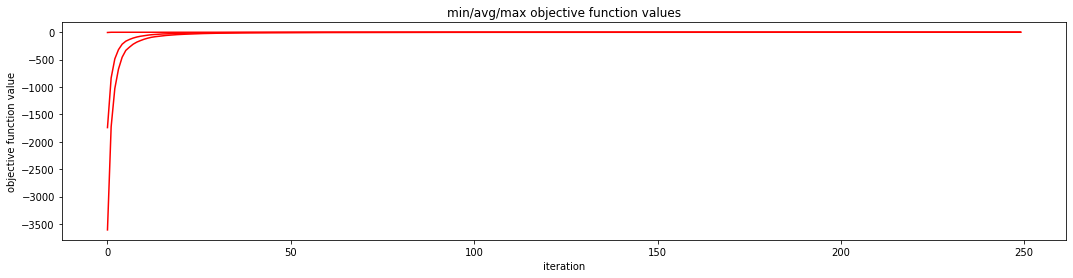

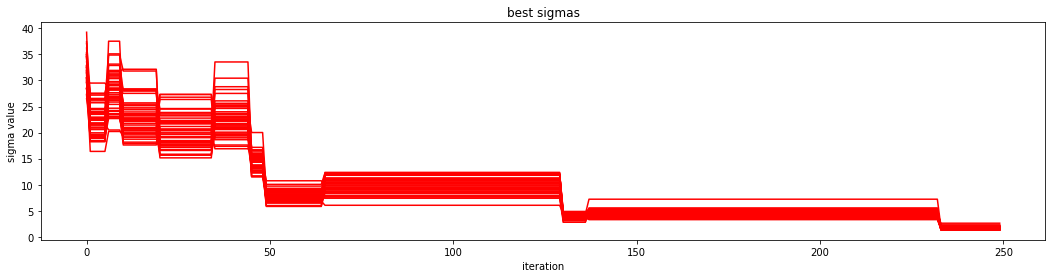

In [142]:
d = 50
N = 1000
T = 250
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es_with_mutations(
    objective_function_F1c, motate2, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas[:,:,0], 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

In [182]:
d = 50
N = 1000
T = 250
#objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es_with_mutations(
    objective_function_F1c, motate3, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 20)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

0.02


LinAlgError: Matrix is not positive definite

## Zadanie 4. (4 punkty)

### a)
Zapoznaj się z problemem kinematyki odwrotnej (Inverse Kinematics Problem).

### b) 
W dalszej części zadania skup się na uproszczonym problemie omówionym na wykładzie, tzn.:
* rozpatrujemy ramię robota, przymocowane do podłoża w punkcie A, złożone z K sztywnych  segmentów prostoliniowych S1, S2, …, SK, o ustalonych długościach l1, l2, …, lK,
* ramię może wyginać się w przegubach zmieniając kąt αk pod którym łączą się dwa kolejne segmenty Sk i Sk-1 (przez S0 oznaczmy podłoże), k = 1, 2, …, K,
* dla każdego kąta αk dany jest przedział [ak, bk] ograniczający zakres jego
wartości, k = 1, 2, …, K,
* dany jest punkt docelowy B,
* zadanie polega na wyznaczeniu wartości kątów α1, α2, …, αK w taki sposób, aby
ramię robota znalazło się jak najbliżej punktu docelowego.

### c)
Napisz algorytm ewolucyjny rozwiązujący problem kinematyki odwrotnej określony w punkcie b. Stwórz przykładowe zestawy danych wejściowych opisujących problem o różnej wielkości i różnym poziomie trudności. Dokładnie przeanalizuj działanie algorytmu i otrzymane wyniki. Sprawdź różne ustawienia algorytmu.

In [284]:
def cost(P, goal, arms, A, B):
    res = np.zeros(len(P))
    max_cost = -100*((0-goal[0])**2 + (0-goal[1])**2)**0.5
    for i,p in enumerate(P):
        a, x, y = 0, 0, 0
        for j,angle in enumerate(p):
            if A[j] > angle or B[j] < angle:
                res[i] = max_cost
                break
            a += angle
            x += arms[j] * np.sin(a*np.pi/180)
            y += arms[j] * np.cos(a*np.pi/180)
        else:
            res[i] = -((x-goal[0])**2 + (y-goal[1])**2)**0.5
    return res

In [225]:
def plot_arm(angles, arms, goal):
    plt.scatter(goal[0], goal[1], color='red', s=50)
    a, x, y = 0, 0, 0
    plt.scatter(x, y, color='black', s=50)
    for j,angle in enumerate(angles):
        a += angle
        new_x = x + arms[j] * np.sin(a*np.pi/180)
        new_y = y + arms[j] * np.cos(a*np.pi/180)
        plt.plot((x,new_x), (y,new_y))
        plt.scatter(new_x, new_y, color='black', s=5)
        x,y = new_x, new_y

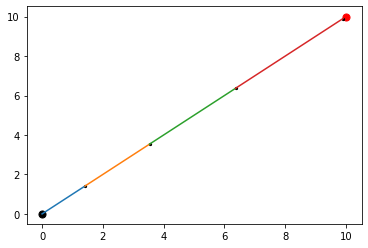

In [236]:
arms = [2,3,4,5]
angles = [45,0,0,0]
goal = [10,10]
plot_arm(angles, arms, goal)

In [237]:
cost([angles],goal,arms,[-360,-360,-360,-360],[360,360,360,360])

array([0.14213562])

Iteration 0000 : best score = -11.27132073, mean score = -17.33483710.
Iteration 0050 : best score = -2.17992437, mean score = -2.32263982.
Iteration 0100 : best score = -0.81582223, mean score = -0.90243288.
Iteration 0150 : best score = -0.27223940, mean score = -0.31021919.
Iteration 0200 : best score = -0.19586803, mean score = -0.19965000.
Iteration 0250 : best score = -0.17070925, mean score = -0.17307421.
Iteration 0300 : best score = -0.15591812, mean score = -0.15660243.
Iteration 0350 : best score = -0.13898573, mean score = -0.14117102.
Iteration 0400 : best score = -0.11770820, mean score = -0.12013588.
Iteration 0450 : best score = -0.09024085, mean score = -0.09217302.
Iteration 0500 : best score = -0.07780260, mean score = -0.07918460.
Iteration 0550 : best score = -0.07072993, mean score = -0.07184765.
Iteration 0600 : best score = -0.06525688, mean score = -0.06595398.
Iteration 0650 : best score = -0.06016449, mean score = -0.06204853.
Iteration 0700 : best score = -0

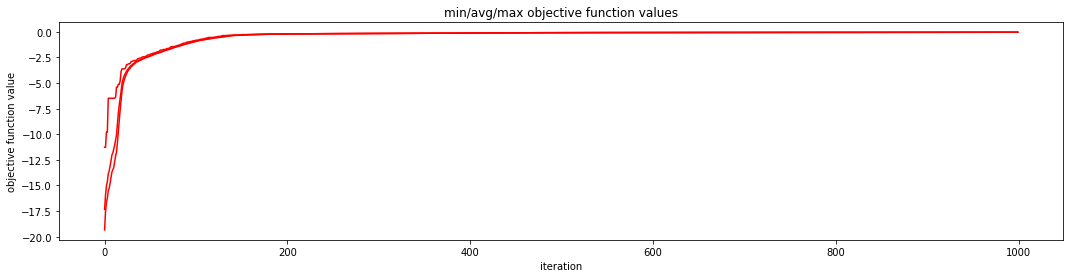

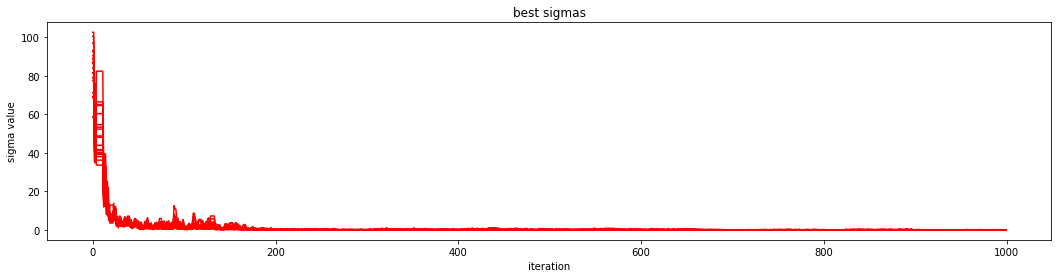

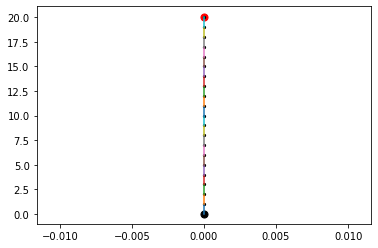

In [257]:
d = 20
N = 100
T = 1000

arms = np.ones(d)
goal = np.array([0,20])
A = np.ones(d) * -360
B = np.ones(d) * 360
obj_func = lambda P: cost(P,goal,arms,A,B)

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    obj_func, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 50)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

plot_arm(history_best_chromosome[-1], arms, goal)

Iteration 0000 : best score = -10.82089985, mean score = -16.53073973.
Iteration 0050 : best score = -0.08933515, mean score = -0.47243721.
Iteration 0100 : best score = -0.01765826, mean score = -0.09980919.
Iteration 0150 : best score = -0.00173512, mean score = -0.02890342.
Iteration 0200 : best score = -0.00046290, mean score = -0.00684991.
Iteration 0250 : best score = -0.00017111, mean score = -0.00116668.
Iteration 0300 : best score = -0.00007306, mean score = -0.00059818.
Iteration 0350 : best score = -0.00001677, mean score = -0.00030082.
Iteration 0400 : best score = -0.00001677, mean score = -0.00016769.
Iteration 0450 : best score = -0.00001210, mean score = -0.00008668.
Iteration 0500 : best score = -0.00000350, mean score = -0.00002586.
Iteration 0550 : best score = -0.00000072, mean score = -0.00000532.
Iteration 0600 : best score = -0.00000038, mean score = -0.00000163.
Iteration 0650 : best score = -0.00000007, mean score = -0.00000042.
Iteration 0700 : best score = -0

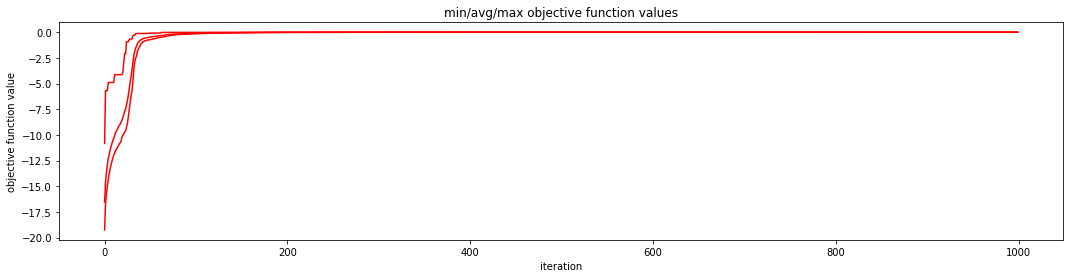

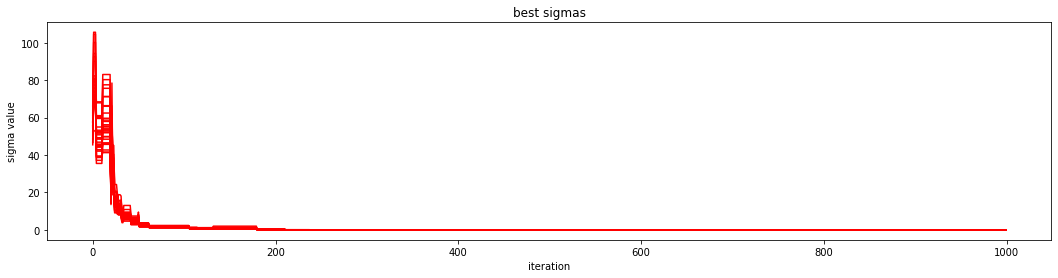

(0, 20)

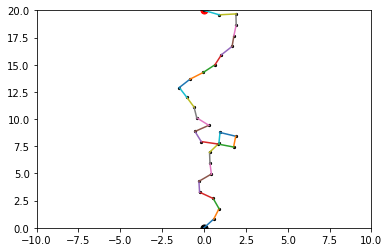

In [270]:
d = 30
N = 100
T = 1000

arms = np.ones(d)
goal = np.array([0,20])
A = np.ones(d) * -360
B = np.ones(d) * 360
obj_func = lambda P: cost(P,goal,arms,A,B)

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    obj_func, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 50)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

plot_arm(history_best_chromosome[-1], arms, goal)
plt.xlim(-10,10)
plt.ylim(0,20)

Iteration 0000 : best score = -14.53106193, mean score = -1425.88957172.
Iteration 0050 : best score = -0.00556995, mean score = -0.03604891.
Iteration 0100 : best score = -0.00002556, mean score = -0.00197513.
Iteration 0150 : best score = -0.00002556, mean score = -0.00066997.
Iteration 0200 : best score = -0.00000444, mean score = -0.00022454.
Iteration 0250 : best score = -0.00000444, mean score = -0.00011102.
Iteration 0300 : best score = -0.00000444, mean score = -0.00006317.
Iteration 0350 : best score = -0.00000288, mean score = -0.00003215.
Iteration 0400 : best score = -0.00000182, mean score = -0.00001726.
Iteration 0450 : best score = -0.00000182, mean score = -0.00001074.
Iteration 0500 : best score = -0.00000182, mean score = -0.00000792.
Iteration 0550 : best score = -0.00000168, mean score = -0.00000592.
Iteration 0600 : best score = -0.00000131, mean score = -0.00000457.
Iteration 0650 : best score = -0.00000098, mean score = -0.00000367.
Iteration 0700 : best score = 

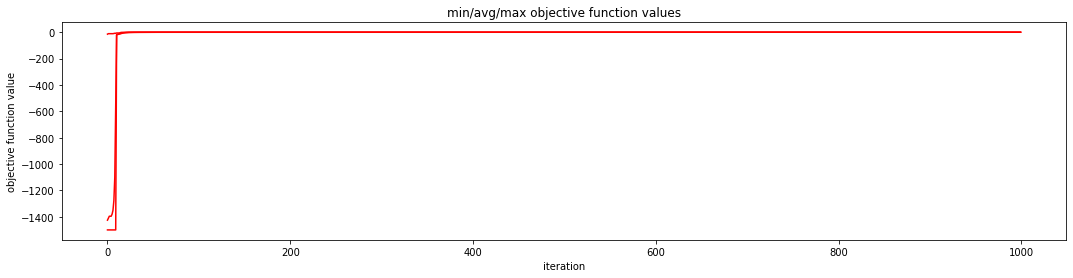

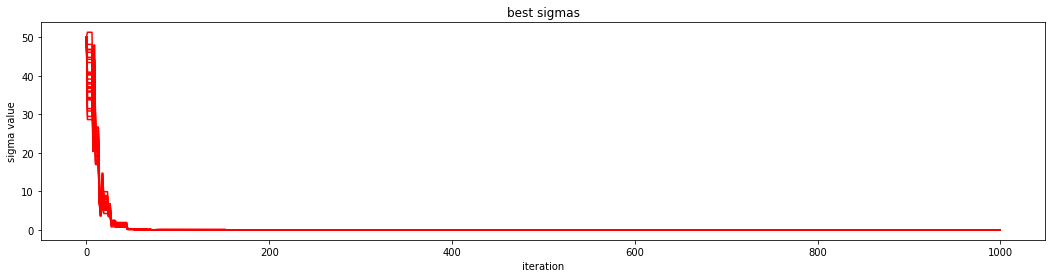

In [286]:
d = 30
N = 100
T = 1000

arms = np.random.randint(0,5,d)
goal = np.array([0,15])
A = np.ones(d) * 10
B = np.ones(d) * 120
obj_func = lambda P: cost(P,goal,arms,A,B)

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    obj_func, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 50)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()


(-5, 20)

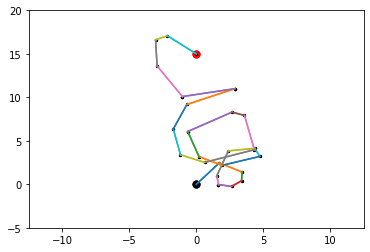

In [288]:
plot_arm(history_best_chromosome[-1], arms, goal)
plot_arm(history_best_chromosome[-1], arms, goal)
plt.xlim(-12.5,12.5)
plt.ylim(-5,20)